### Loading Data
Dan Constantini, Tom Hayat et Alexandre Attia
This script loads 11 data class from imagenet and sort the files according to their name

In [32]:
require 'torch'
require 'xlua'
require 'image'


--classes={'bridge', 'building', 'city', 'eiffel_tower','elephant', 'landscape', 'lion', 'monkey', 'people', 'tower', 'water'}


imagesAll = torch.Tensor(1721,3,64,64) 
labelsAll = torch.Tensor(1721)
compteur = 0
for dir in paths.iterdirs("./dataset/train/") do
    --print(dir)
    compteur = compteur +1
    files = {}
    for file in paths.files(paths.concat('./dataset/train/', dir)) do
       if file:find('JPEG' .. '$') then
            --print(paths.concat(paths.concat('./dataset/train/',dir),file))
          table.insert(files, paths.concat(paths.concat('./dataset/train/',dir), file))
       end
    end
   
    if #files == 0 then
       error('given directory doesnt contain any files of type: ')
    end


    for i=1,(#files) do
        print('dossier : ', compteur)
        print(#files)
        temp = image.load(files[i])
        --print(files[i])
        if (temp:size()[1]==3) then
            imagesAll[i] = image.load(files[i]) 
            labelsAll[i] = compteur
        end
    end
    collectgarbage()
end
print(#files)

dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	


185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	

1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	


185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	


185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	

1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	

1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	
dossier : 	1	
185	
dossier : 	1	
185	


dossier : 	1	
185	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	

2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	

2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	

2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	
dossier : 	2	
157	
dossier : 	2	
157	


dossier : 	2	
157	


dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	


85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	3	
85	
dossier : 	3	
85	


dossier : 	4	
17	


dossier : 	4	
17	
dossier : 	4	
17	


dossier : 	4	
17	
dossier : 	4	
17	


dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	


dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	


dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	
dossier : 	4	
17	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	


223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	
dossier : 	5	
223	


dossier : 	5	
223	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	

6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	
dossier : 	6	
44	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	


288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	


288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	

7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	

7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	

7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	

7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	7	
288	
dossier : 	7	
288	
dossier : 	7	
288	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	


215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	


215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	8	
215	
dossier : 	8	
215	


dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	9	
164	
dossier : 	9	
164	
dossier : 	9	
164	


dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	


153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	


153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	
dossier : 	10	
153	
dossier : 	10	
153	


dossier : 	10	
153	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	


190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


dossier : 	11	
190	
dossier : 	11	
190	
dossier : 	11	
190	


190	


In [2]:
trainData = {
   data = torch.Tensor(1721, 3, 64, 64),
   labels = torch.Tensor(1721),
}
--[[create test set:
testData = {
      data = torch.Tensor(tesize, 1, 32, 32),
      labels = torch.Tensor(tesize),
      size = function() return tesize end
   }
]]--

for i=1,1721 do
   trainData.data[i] = imagesAll[i]
   trainData.labels[i] = labelsAll[i]
end
--for i=trsize+1,tesize+trsize do
   --testData.data[i-trsize] = imagesAll[labelsShuffle[i]][1]:clone()
   --testData.labels[i-trsize] = labelsAll[labelsShuffle[i]]
--end

In [3]:
trainData

{
  data : DoubleTensor - size: 1721x3x64x64
  labels : DoubleTensor - size: 1721
}


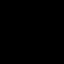

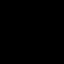

In [22]:
itorch.image(trainData.data[288])
itorch.image(imagesAll[1538])
--print(trainData.labels)

In [35]:
labels_nul=0
for i=1,1721 do
    if (trainData.labels[i]~=0) then
           labels_nul=labels_nul+1
    end
end
print(labels_nul)

287	


<b>Problème :</b> à partir de l'image 288, les images sont entierement noirs et le label est nul. Je pense qu'il y a un probleme avec le `if (temp:size()[1]==3) then` ! En fait c'est avant je crois, quand on print le nombre de files ils en mettent que 190 .. --> J'ai compris on a un probleme dans la boucle, en fait, elle repart de 0 à chaque fois pour imageAll, donc à chaque fois qu'on parcourt un repertory d'images on réécrit sur les images anciennes (la liste `files` est temporaire. Le nombres d'images dans imagesAll est donc 288 car le nombre maximal d'images des dossiers du dataset est 288. 

``for i=1,(#files) do
        print('dossier : ', compteur)
        print(#files)
        temp = image.load(files[i])
        --print(files[i])
        if (temp:size()[1]==3) then
            imagesAll[i] = image.load(files[i]) 
            labelsAll[i] = compteur
        end
    end
``

Est ce que ce code là on le sort pas de la grosse boucle ?

## Preprocessing Data